## Machine Learning - Desafío 3, Naive Bayes
#### Gustavo Morales, G10 - 13.Ene.2020, (Lunes Semana 2)

### **Ejercicio 1: Preparar el ambiente de trabajo**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
import glob
import os
import itertools

In [2]:
CWD = os.getcwd()

for name in glob.glob(CWD+'/*'):
    print(name)

/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/desafio_03_Gustavo_Morales.ipynb
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/desafio_03_Gustavo_Morales.zip
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/dump
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/dump_plus_pop
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/Desafio_Naive_Bayes_Eduardo_Lopez.ipynb
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/Desafio_Analisis_Lineal_Discriminante_Eduardo_Lopez.ipynb
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/desafio_04_Gustavo_Morales.ipynb
/home/gus/learn/courses/dlatam_ds/desafios/m3_w02/02_d_Desafío_-_Naive_Bayes.pdf


In [3]:
route = glob.glob('dump/*.csv')

In [4]:
dfs = []

for fname in route:
    df_aux = pd.read_csv(fname, header=0)
    dfs.append(df_aux)

In [5]:
df = pd.concat(dfs, axis=0, ignore_index=True, sort=True)
df.drop(columns='Unnamed: 0', inplace=True)
df.rename(columns={'0': 'artist', '1': 'genre', '2': 'song', '3': 'lyrics'}, inplace=True)

In [6]:
df.sample(10)

,artist,genre,song,lyrics
1855,Weezer,rock,Unbreak My Heart,Don't leave me in all this pain \n Don't leave...
6322,The Beatles,rock,Penny Lane,In Penny Lane there is a barber showing photog...
7496,Led Zeppelin,rock,I'm Gonna Crawl,"Oh, she's my baby \n Let me tell you why \n He..."
6794,Eminem,hiphop,Freestyle I,Im driven to write \n Given the mic \n Livin' ...
3477,Queen,rock,Ogre Battle,Now once upon a time \n An old man told me a f...
7360,A Tribe Called Quest,hiphop,The Pressure,(Q-Tip) \n In this American metropolis filled ...
6907,Eminem,hiphop,Slim Shade EP,May I have your attention please \n Will the R...
2891,Bruce Springsteen,rock,Dancing In The Dark,I get up in the evening \n And I ain't got not...
3985,Anthrax,metal,Madhouse,"It's time for your medication, Mr. Brown \n Oo..."
2670,Britney Spears,pop,State Of Grace,Love is a state of grace \n Transcending time ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9489 entries, 0 to 9488
Data columns (total 4 columns):
artist    9489 non-null object
genre     9489 non-null object
song      9489 non-null object
lyrics    9489 non-null object
dtypes: object(4)
memory usage: 296.7+ KB


In [8]:
df.isnull().sum(axis = 0)  # NaN distribution columnwise

artist    0
genre     0
song      0
lyrics    0
dtype: int64

### **Ejercicio 2: Descripción de los datos**

##### ($2.1$) Cantidad de canciones registradas por cada artista en orden decreciente:

In [9]:
df['artist'].value_counts().rename_axis('artist').reset_index(name='counts')

,artist,counts
0,Eminem,493
1,Bruce Springsteen,467
2,Bob Dylan,447
3,Britney Spears,323
4,Nicki Minaj,282
...,...,...
56,Dua Lipa,29
57,Lorde,27
58,Black Star,23
59,Necrophagist,16


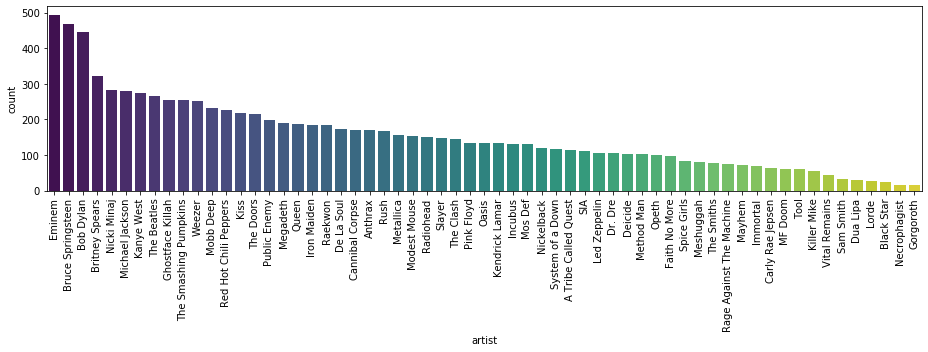

In [10]:
plt.figure(figsize=(13,5))
chart = sns.countplot(data=df, x='artist', order = df['artist'].value_counts().index, palette='viridis')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.tight_layout()

##### $(2.2)$ Cantidad de canciones registradas por cada género en orden decreciente:

In [11]:
df['genre'].value_counts().rename_axis('genre').reset_index(name='counts')

,genre,counts
0,rock,4140
1,hiphop,2535
2,metal,1582
3,pop,1232


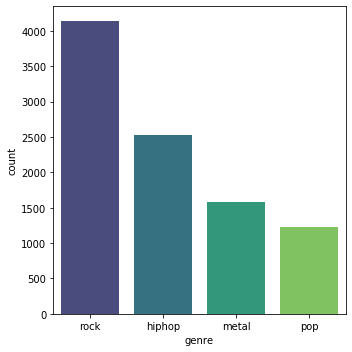

In [12]:
plt.figure(figsize=(5,5))
chart = sns.countplot(data=df, x='genre', order = df['genre'].value_counts().index, palette='viridis')
plt.tight_layout()

##### $(2.3)$ Principales tendencias:

**(R)** De acuerdo a $(2.1)$, el top 5 de artistas con más canciones es:

In [13]:
df['artist'].value_counts().head(5)

Eminem               493
Bruce Springsteen    467
Bob Dylan            447
Britney Spears       323
Nicki Minaj          282
Name: artist, dtype: int64

Y de acuerdo a $(2.2)$, el género más prolífero es el **rock**, seguido del **hiphop**.

### **Ejercicio 3: Matriz de ocurrencias**

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

**(R)** En análisis computacional de textos, un _token_ es una unidad funcional de texto que generaliza el concepto de palabras (típicamente separados por espacios). `CountVectorizer` convierte una colección de documentos de texto a una matriz de cuentas de _tokens_, proveyendo una manera de _tokenizar_ dicha colección construyendo un vocabulario de palabras conocidas, a la vez que permite codificar nuevos documentos usando dicho vocabulario.

In [15]:
def top100_words(dataframe, genre=None):
    df_ = dataframe
    if genre!=None:
        df_ = dataframe[dataframe['genre'] == genre]
    count_vectorizer = CountVectorizer(stop_words = 'english')
    count_vectorizer_fit = count_vectorizer.fit_transform(df_['lyrics'])
    words = count_vectorizer.get_feature_names()
    words_freq = count_vectorizer_fit.toarray().sum(axis = 0)
    df__ = pd.DataFrame({'words':words, 'frequency':words_freq})
    print(genre) if genre!=None else print('')
    print(df__.sort_values('frequency', ascending = False).head(100))

**(R)** Las 100 palabras mas repetidas en canciones en todo el data set:

In [16]:
top100_words(df)


       words  frequency
24950   like      19629
12859    don      17398
23856   know      14962
18439    got      14171
23287   just      13978
...      ...        ...
11041  death       1897
24615   left       1895
43442  thing       1882
14305    end       1829
41068   stay       1828

[100 rows x 2 columns]


**(R)** Las 100 palabras mas repetidas por género:

In [17]:
genres =  ['rock', 'hiphop', 'metal', 'pop']
for genre in genres:
    top100_words(df, genre=genre)
    print('------------------------')

rock
       words  frequency
5282     don       5284
10362   love       5114
9697    know       4702
12077     oh       4258
20056   yeah       4157
...      ...        ...
18247   town        558
6337    fall        548
14819  round        548
4527    days        542
10335   lost        541

[100 rows x 2 columns]
------------------------
hiphop
        words  frequency
18361    like      12055
13533     got       7613
9466      don       7604
17532    know       6535
17082    just       6272
...       ...        ...
31521    talk        823
18961      ma        821
34088   verse        820
5866   chorus        811
3911     bout        808

[100 rows x 2 columns]
------------------------
metal
       words  frequency
7883    life       1233
4088     don       1181
3284   death       1139
13844   time       1096
7977      ll       1069
...      ...        ...
13839   till        215
5939    good        214
11666   save        213
13041   stop        211
8034    lord        210

[100 ro

**(R)**
- Palabras como `don` (provenientes de `don't`) tienden a ser independientes del género.
- Palabras como `love` y `like` tienden a repetirse mucho, excepto en el metal.
- En este último, naturalmente las palabras más repetidas son `life`, `death`, `lord`, etc.

#### **Ejercicio 4: Entrenamiento del Modelo**

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [19]:
X = df['lyrics']
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 42)

In [20]:
pipeline = Pipeline(
    [
        ('cvect', CountVectorizer(stop_words = 'english')),
        ('mnbay', MultinomialNB())
    ]
)

In [22]:
pipeline.fit(X_train, y_train);
# pipeline.named_steps.countvect.get_feature_names()

In [23]:
to_predict = pd.Series(np.array(
    ["I got a place in the underworld",
     "As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara", 
     "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie",
     "Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way",
     "Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates",
     "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving"
    ]))

In [24]:
pipeline.predict(to_predict)

array(['rock', 'metal', 'rock', 'pop', 'metal', 'rock'], dtype='<U6')

**(R)** Contraste con la predicción: la predicción es regular; 2 de 6 correctas. `Pop` en general da problemas.

| Artist       | my prediction     | Google says |
|--------------|-------------------|-------------|
| Broddy Dale  | Rock              | Rock        |
| Gorguts      | Metal             | Metal       |
| N'SYNC       | Rock              | Pop         |
| Ludacris     | Pop               | Hiphop      |
| IDLES        | Metal             | Rock        |
| Banks        | Rock              | Pop         |

In [25]:
y_prediction = pipeline.predict(X_test)

In [26]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

      hiphop       0.85      0.93      0.89      1003
       metal       0.83      0.69      0.75       645
         pop       0.64      0.37      0.47       461
        rock       0.77      0.86      0.81      1687

    accuracy                           0.79      3796
   macro avg       0.77      0.71      0.73      3796
weighted avg       0.78      0.79      0.78      3796



In [27]:
classifier = pipeline.fit(X_train, y_train)

In [28]:
def plot_confusion_matrix(cm,
                          target_names = ['1', '2', '3', '4'],
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = False):
    # plt.rcParams["axes.grid"] = False

    accuracy = np.trace(cm) / float(np.sum(cm))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    # plt.grid(None)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))

In [29]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_prediction)

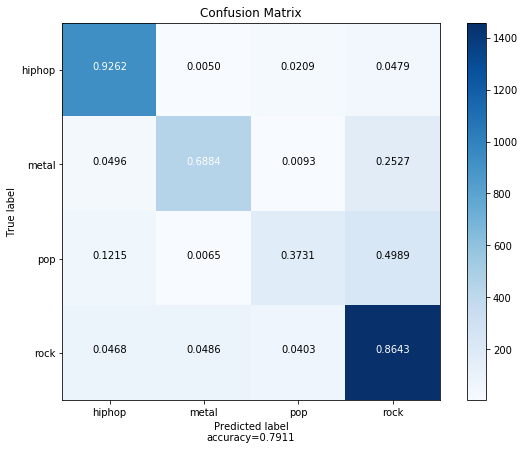

In [30]:
plot_confusion_matrix(cm           = (confusion), 
                      normalize    = True,
                      target_names = ['hiphop', 'metal', 'pop', 'rock'],
                      title        = 'Confusion Matrix')

#### **Ejercicio 5: Mejora del Modelo**

In [31]:
route2 = glob.glob('dump_plus_pop/*.csv')

In [32]:
dfs2 = []

for fname in route2:
    df_aux = pd.read_csv(fname, header=0)
    dfs2.append(df_aux)

In [33]:
df2 = pd.concat(dfs2, axis=0, ignore_index=True, sort=True)
df2.drop(columns='Unnamed: 0', inplace=True)
df2.rename(columns={'0': 'artist', '1': 'genre', '2': 'song', '3': 'lyrics'}, inplace=True)
df2.sample(10)

,artist,genre,song,lyrics
3448,Bruce Springsteen,rock,O Mary Don't You Weep,Well if I could I surely would \n Stand on the...
1183,The Smashing Pumpkins,rock,"Tonight, Tonight",Time is never time at all \n You can never eve...
10023,Mos Def,hiphop,The Easy Spell,You turn me up a lil'.. \n I'm gettin' a lotta...
221,Method Man,hiphop,Perfect World,"(Dialogue) \n First, they dropped the bomb \n ..."
6847,Raekwon,hiphop,Wake Up,"(One) gun go off, showin' everything is lost \..."
3731,New Kids On The Block,pop,Dirty Dancing,Wasn't in the mood for dancin' forget about ro...
2638,Pink Floyd,rock,Yet Another Movie,"One sound, one single sound \n One kiss, one s..."
2918,Britney Spears,pop,I Run Away,You took your love away too fast \n Left no ch...
5351,Killer Mike,hiphop,A.D.I.D.A.S.,Pussy nigga whatcha doin'! \n All day I dream ...
7374,The Beatles,rock,One And One Is Two,One and one is two \n What am I to do \n Now t...


In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10804 entries, 0 to 10803
Data columns (total 4 columns):
artist    10804 non-null object
genre     10804 non-null object
song      10804 non-null object
lyrics    10804 non-null object
dtypes: object(4)
memory usage: 337.8+ KB


In [35]:
df2.isnull().sum(axis = 0)  # NaN distribution columnwise

artist    0
genre     0
song      0
lyrics    0
dtype: int64

In [36]:
X2 = df2['lyrics']
y2 = df2['genre']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .4, random_state = 42)

In [37]:
pipeline2 = Pipeline(
    [
        ('cvect2', CountVectorizer(stop_words = 'english')),
        ('mnbay2', MultinomialNB())
    ]
)

In [38]:
pipeline2.fit(X2_train, y2_train);

In [39]:
pipeline2.predict(to_predict)

array(['rock', 'metal', 'pop', 'pop', 'metal', 'pop'], dtype='<U6')

**(R)** Contraste con la predicción: Mejora bastante con 4 de 6 correctas, con el resto bastante cercano.

| Artist       | my 2nd prediction     | Google says |
|--------------|-------------------|-------------|
| Broddy Dale  | Rock              | Rock        |
| Gorguts      | Metal             | Metal       |
| N'SYNC       | Pop               | Pop         |
| Ludacris     | Pop               | Hiphop      |
| IDLES        | Metal             | Rock        |
| Banks        | Pop               | Pop         |

In [40]:
y2_prediction = pipeline2.predict(X2_test)

In [41]:
print(classification_report(y2_test, y2_prediction))

              precision    recall  f1-score   support

      hiphop       0.85      0.90      0.87      1029
       metal       0.81      0.69      0.75       621
         pop       0.68      0.68      0.68      1012
        rock       0.75      0.76      0.75      1660

    accuracy                           0.76      4322
   macro avg       0.77      0.76      0.76      4322
weighted avg       0.76      0.76      0.76      4322



In [42]:
confusion2 = confusion_matrix(y2_test, y2_prediction)

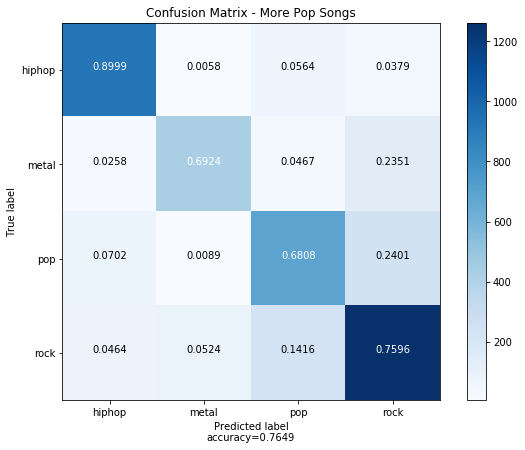

In [43]:
plot_confusion_matrix(cm           = (confusion2), 
                      normalize    = True,
                      target_names = ['hiphop', 'metal', 'pop', 'rock'],
                      title        = 'Confusion Matrix - More Pop Songs')

**(R)** En general mejoraron las métricas y las clasificaciones correctas - especialmente para `Pop` - cuyo F1 score subió significativamente. Esto demuestra lo relevante que es tener más datos para cada clase.